In [1]:
import os

import numpy as np
import pandas as pd
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

from data import *


SEED = 662
DATA_DIR = "processed"
storage = f"sqlite:///random_forest.db"

data = remove_boring_columns(
    transform_all_house(combined_transformed_train_with_num_pov)
)

/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/borisleung/Desktop/STA841Kaggle/data.py:282: FutureWarning: using <built-in method join of str object at 0x100ca5770> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df[fathers_in_house_mask]["psu_hh_idcode"].str.split("_").str[:-1].agg("_".join)
/Users/borisleung/Desktop/STA841Kaggle/data.py:251: FutureWarning: using <built-in method join of str object at 0x100ca5770> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df[mothers_in_house_mask]["psu_hh_idcode"].str.split("_").str[:-1].agg("_".join)


In [3]:
import logging
import sys

from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split

from models import *


def load_objective(
    X: pd.DataFrame,
    y: pd.DataFrame,
    y_binarized: pd.DataFrame,
    get_trained_model: callable,
):
    X.replace(-999, np.nan, inplace=True)

    def objective(trial: optuna.Trial):
        chi2_threshold = trial.suggest_int("chi2_threshold", 2, 100)
        # cv = trial.suggest_int("cv", 3, 5)
        cv = 3
        imputer_strategy = trial.suggest_categorical(
            "imputer_strategy", ["mean", "median", "most_frequent"]
        )

        train_losses, valid_losses, valid_loss_shift, n_iters = [], [], [], []
        X_train, X_valid, y_train, y_valid, y_train_binarized, y_valid_binarized = (
            train_test_split(X, y, y_binarized, test_size=1 / cv, random_state=SEED)
        )  # lazy, just do 1 round of cv

        # add pov means aggregated by psu
        aggregated_pov_train_data = pd.concat(
            [X_train["psu_hh_idcode"], y_train], axis=1
        )
        aggregated_pov_train_data[["psu", "hh", "idcode"]] = aggregated_pov_train_data[
            "psu_hh_idcode"
        ].str.split("_", expand=True)
        df_mean = aggregated_pov_train_data.groupby("psu")["num_pov"].mean()
        X_train_means = pd.merge(
            aggregated_pov_train_data,
            df_mean,
            on="psu",
            how="left",
            suffixes=("", "_mean"),
        )["num_pov_mean"]
        X_train_means.replace(np.nan, X_train_means.mean(), inplace=True)

        X_valid[["psu", "hh", "idcode"]] = X_valid["psu_hh_idcode"].str.split(
            "_", expand=True
        )
        X_valid_means = pd.merge(
            X_valid,
            df_mean,
            on="psu",
            how="left",
            suffixes=("", "_mean"),
        )["num_pov"]
        X_valid_means.replace(np.nan, X_valid_means.mean(), inplace=True)
        X_valid_means.rename("num_pov_mean", inplace=True)

        preprocessor = get_preprocessor(
            # ordinal_transformer=Pipeline([("imputer", "passthrough")]),
            imputer_strategy=[
                "most_frequent",
                "most_frequent",
                imputer_strategy,
                imputer_strategy,
            ],
            remainder="drop",
        )

        X_train_processed = preprocessor.fit_transform(X_train)
        selector = SelectPercentile(chi2, percentile=chi2_threshold)
        X_train = selector.fit_transform(X_train_processed, y_train)
        X_train = np.column_stack([X_train, X_train_means])

        X_valid = preprocessor.transform(X_valid)
        X_valid = selector.transform(X_valid)
        X_valid = np.column_stack([X_valid, X_valid_means])

        model = get_trained_model(
            trial, seed=SEED, X_train=X_train, y_train=y_train - 1
        )
        train_losses.append(log_loss(y_train_binarized, model.predict_proba(X_train)))

        y_pred = model.predict_proba(X_valid)
        for column_index in [
            column for column in range(10) if column not in model.classes_
        ]:
            y_pred = np.insert(y_pred, column_index - 1, 0, axis=1)

        valid_losses.append(log_loss(y_valid_binarized, y_pred))
        valid_loss_shift.append(valid_losses[-1] - train_losses[-1])
        # n_iters.append(model.n_iter_[0])

        mean_valid_loss = np.mean(valid_losses)
        trial.set_user_attr(
            "selected_columns",
            X_train_processed.columns[selector.get_support()].values.tolist(),
        )
        # trial.set_user_attr("n_iter", np.mean(n_iters))
        trial.set_user_attr("train_loss", np.mean(train_losses))
        trial.set_user_attr("valid_loss_shift", np.mean(valid_loss_shift))
        return mean_valid_loss

    return objective


def get_random_forest(trial, seed, X_train, y_train):
    model = suggest_random_forest(trial, seed)
    model.fit(X_train, y_train)
    return model


optuna.logging.set_verbosity(optuna.logging.ERROR)

poi = data
nunique = poi.nunique()
cols_to_drop = nunique[nunique == 1].index
poi = poi.drop(cols_to_drop, axis=1)
poi = poi.drop(columns=["edu_q09", "edu_q10", "edu_q11", "edu_q12", "edu_q13"])
print(poi.shape)
X, y, y_binarized = (
    poi.drop(Y_COLUMNS + ["num_pov"], axis=1),
    poi["num_pov"],
    poi[Y_COLUMNS],
)

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
optuna.logging.set_verbosity(optuna.logging.WARNING)
storage = f"sqlite:///random_forest.db"
study_name = "random-forest"
study = optuna.create_study(
    direction="minimize", storage=storage, study_name=study_name, load_if_exists=True
)
study.optimize(
    load_objective(X, y, y_binarized, get_random_forest),
    n_trials=1000,
    n_jobs=-1,
    show_progress_bar=True,
)
# print(optuna.importance.get_param_importances(study))
# print(study.best_trial.user_attrs)
# print(best_values), print(best_params)

(5337, 83)


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transfor

In [4]:
aggregated_pov_entire_train_data = pd.concat(
    [data["psu_hh_idcode"], data["num_pov"]], axis=1
)
aggregated_pov_entire_train_data[["psu", "hh", "idcode"]] = (
    aggregated_pov_entire_train_data["psu_hh_idcode"].str.split("_", expand=True)
)
df_mean = aggregated_pov_entire_train_data.groupby("psu")["num_pov"].mean()
X_entire_train_mean = pd.merge(
    aggregated_pov_entire_train_data,
    df_mean,
    on="psu",
    how="left",
    suffixes=("", "_mean"),
)["num_pov_mean"]
X_entire_train_mean.replace(np.nan, X_entire_train_mean.mean(), inplace=True)

combined_test[["psu", "hh", "idcode"]] = combined_test["psu_hh_idcode"].str.split(
    "_", expand=True
)
X_test_means = pd.merge(
    combined_test,
    df_mean,
    on="psu",
    how="left",
    suffixes=("", "_mean"),
)["num_pov"]
X_test_means.replace(np.nan, X_test_means.mean(), inplace=True)
X_test_means.rename("num_pov_mean", inplace=True)

0       4.400000
1       4.400000
2       4.400000
3       4.000000
4       4.571429
          ...   
1329    4.400000
1330    5.142857
1331    5.200000
1332    5.200000
1333    5.200000
Name: num_pov_mean, Length: 1334, dtype: float64

In [5]:
from sklearn.feature_selection import SelectPercentile, chi2

random_forest_study = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name="random-forest",
    load_if_exists=True,
)
best_random_forest_trial = random_forest_study.best_trial
chi2_percentage_threshold = best_random_forest_trial.params["chi2_threshold"]

random_forest_preprocessor = get_preprocessor(
    imputer_strategy=[
        "most_frequent",
        "most_frequent",
        best_random_forest_trial.params["imputer_strategy"],
        best_random_forest_trial.params["imputer_strategy"],
    ],
    remainder="drop",
)
X_processed = random_forest_preprocessor.fit_transform(X)
selector = SelectPercentile(chi2, percentile=chi2_percentage_threshold)
X_processed = selector.fit_transform(X_processed, y)
X_processed = np.column_stack([X_processed, X_entire_train_mean])

final_model = RandomForestClassifier(
    n_estimators=best_random_forest_trial.params["n_estimators"],
    criterion=best_random_forest_trial.params["criterion"],
    max_features=best_random_forest_trial.params["max_features"],
    max_depth=best_random_forest_trial.params["max_depth"],
    min_samples_split=best_random_forest_trial.params["min_samples_split"],
    min_samples_leaf=best_random_forest_trial.params["min_samples_leaf"],
    random_state=SEED,
)

final_model.fit(X_processed, y)
final_y_train_pred = final_model.predict_proba(X_processed)

log_loss(y_binarized, final_y_train_pred)

1.5638401989944408

Submission file saved as random-forest-1.csv


/Users/borisleung/Desktop/STA841Kaggle/data.py:282: FutureWarning: using <built-in method join of str object at 0x100ca5770> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df[fathers_in_house_mask]["psu_hh_idcode"].str.split("_").str[:-1].agg("_".join)
/Users/borisleung/Desktop/STA841Kaggle/data.py:251: FutureWarning: using <built-in method join of str object at 0x100ca5770> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df[mothers_in_house_mask]["psu_hh_idcode"].str.split("_").str[:-1].agg("_".join)
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3

<Axes: >

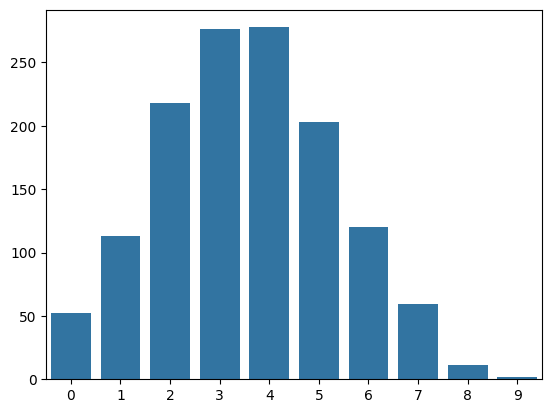

In [7]:
import seaborn as sns

from data import generate_submission, combined_test

X_submissions = remove_boring_columns(transform_all_house(combined_transformed_test))
X_submissions_scaled = random_forest_preprocessor.transform(X_submissions)
X_submissions_scaled = selector.transform(X_submissions_scaled)
X_submissions_scaled = np.column_stack([X_submissions_scaled, X_test_means])
final_y_pred = final_model.predict_proba(X_submissions_scaled)

generate_submission(final_y_pred, "random-forest")
sns.barplot(final_y_pred.sum(axis=0))

## with knn means


In [12]:
import logging
import sys

from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsTransformer

from models import *


def load_objective(
    X: pd.DataFrame,
    y: pd.DataFrame,
    y_binarized: pd.DataFrame,
    get_trained_model: callable,
):
    X.replace(-999, np.nan, inplace=True)

    def objective(trial: optuna.Trial):
        chi2_threshold = trial.suggest_int("chi2_threshold", 2, 100)
        # cv = trial.suggest_int("cv", 3, 5)
        cv = 3
        imputer_strategy = trial.suggest_categorical(
            "imputer_strategy", ["mean", "median", "most_frequent"]
        )

        train_losses, valid_losses, valid_loss_shift, n_iters = [], [], [], []
        X_train, X_valid, y_train, y_valid, y_train_binarized, y_valid_binarized = (
            train_test_split(X, y, y_binarized, test_size=1 / cv, random_state=SEED)
        )  # lazy, just do 1 round of cv

        # add pov means aggregated by psu
        aggregated_pov_train_data = pd.concat(
            [X_train["psu_hh_idcode"], y_train], axis=1
        )
        aggregated_pov_train_data[["psu", "hh", "idcode"]] = aggregated_pov_train_data[
            "psu_hh_idcode"
        ].str.split("_", expand=True)
        df_mean = aggregated_pov_train_data.groupby("psu")["num_pov"].mean()
        X_train_means = pd.merge(
            aggregated_pov_train_data,
            df_mean,
            on="psu",
            how="left",
            suffixes=("", "_mean"),
        )["num_pov_mean"]
        X_train_means.replace(np.nan, X_train_means.mean(), inplace=True)

        X_valid[["psu", "hh", "idcode"]] = X_valid["psu_hh_idcode"].str.split(
            "_", expand=True
        )
        X_valid_means = pd.merge(
            X_valid,
            df_mean,
            on="psu",
            how="left",
            suffixes=("", "_mean"),
        )["num_pov"]
        X_valid_means.replace(np.nan, X_valid_means.mean(), inplace=True)
        X_valid_means.rename("num_pov_mean", inplace=True)

        preprocessor = get_preprocessor(
            # ordinal_transformer=Pipeline([("imputer", "passthrough")]),
            imputer_strategy=[
                "most_frequent",
                "most_frequent",
                imputer_strategy,
                imputer_strategy,
            ],
            remainder="drop",
        )
        X_train_processed = preprocessor.fit_transform(X_train)
        selector = SelectPercentile(chi2, percentile=chi2_threshold)
        X_train = selector.fit_transform(X_train_processed, y_train)
        X_valid = preprocessor.transform(X_valid)
        X_valid = selector.transform(X_valid)

        # add knn means too
        p = trial.suggest_int("p", 1, 3)
        k_neighbors = trial.suggest_int("k_neighbors", 2, 15)
        transformer = KNeighborsTransformer(
            mode="connectivity", n_neighbors=k_neighbors, p=p
        )
        X_dist_graph = transformer.fit_transform(X_train)
        X_dist_graph.setdiag(0)
        knn_train_means = np.divide(
            (X_dist_graph @ y_train.T), np.asarray(X_dist_graph.sum(axis=1)).flatten()
        )
        np.nan_to_num(knn_train_means, nan=np.nanmean(knn_train_means), copy=False)
        knn_valid_means = (
            (transformer.kneighbors_graph(X_valid) @ y_train.T) / k_neighbors
        ).reshape(-1, 1)
        np.nan_to_num(knn_valid_means, nan=np.nanmean(knn_train_means), copy=False)

        # combining
        X_train = np.column_stack(
            [X_train, X_train_means, knn_train_means.reshape(-1, 1)]
        )
        X_valid = np.column_stack(
            [X_valid, X_valid_means, knn_valid_means.reshape(-1, 1)]
        )

        model = get_trained_model(
            trial, seed=SEED, X_train=X_train, y_train=y_train - 1
        )
        train_losses.append(log_loss(y_train_binarized, model.predict_proba(X_train)))

        y_pred = model.predict_proba(X_valid)
        for column_index in [
            column for column in range(10) if column not in model.classes_
        ]:
            y_pred = np.insert(y_pred, column_index - 1, 0, axis=1)

        valid_losses.append(log_loss(y_valid_binarized, y_pred))
        valid_loss_shift.append(valid_losses[-1] - train_losses[-1])
        # n_iters.append(model.n_iter_[0])

        mean_valid_loss = np.mean(valid_losses)
        trial.set_user_attr(
            "selected_columns",
            X_train_processed.columns[selector.get_support()].values.tolist(),
        )
        # trial.set_user_attr("n_iter", np.mean(n_iters))
        trial.set_user_attr("train_loss", np.mean(train_losses))
        trial.set_user_attr("valid_loss_shift", np.mean(valid_loss_shift))
        return mean_valid_loss

    return objective


def get_random_forest(trial, seed, X_train, y_train):
    model = suggest_random_forest(trial, seed)
    model.fit(X_train, y_train)
    return model


optuna.logging.set_verbosity(optuna.logging.ERROR)

poi = data
nunique = poi.nunique()
cols_to_drop = nunique[nunique == 1].index
poi = poi.drop(cols_to_drop, axis=1)
poi = poi.drop(columns=["edu_q09", "edu_q10", "edu_q11", "edu_q12", "edu_q13"])
print(poi.shape)
X, y, y_binarized = (
    poi.drop(Y_COLUMNS + ["num_pov"], axis=1),
    poi["num_pov"],
    poi[Y_COLUMNS],
)

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_name = "random-forest2"
study = optuna.create_study(
    direction="minimize", storage=storage, study_name=study_name, load_if_exists=True
)
study.optimize(
    load_objective(X, y, y_binarized, get_random_forest),
    n_trials=1000,
    n_jobs=-1,
    show_progress_bar=True,
)
# print(optuna.importance.get_param_importances(study))
# print(study.best_trial.user_attrs)
# print(best_values), print(best_params)

(5337, 83)


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during tr

In [14]:
from sklearn.feature_selection import SelectPercentile, chi2

random_forest_study2 = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name="random-forest2",
    load_if_exists=True,
)
best_random_forest_trial2 = random_forest_study2.best_trial
chi2_percentage_threshold2 = best_random_forest_trial2.params["chi2_threshold"]

random_forest_preprocessor2 = get_preprocessor(
    imputer_strategy=[
        "most_frequent",
        "most_frequent",
        best_random_forest_trial2.params["imputer_strategy"],
        best_random_forest_trial2.params["imputer_strategy"],
    ],
    remainder="drop",
)


X_processed2 = random_forest_preprocessor2.fit_transform(X)
selector2 = SelectPercentile(chi2, percentile=chi2_percentage_threshold2)
X_processed2 = selector2.fit_transform(X_processed2, y)
X_processed2 = np.column_stack([X_processed2, X_entire_train_mean])

random_forest_p2 = best_random_forest_trial2.params["p"]
random_forest_k_neighbors = best_random_forest_trial2.params["k_neighbors"]
transformer2 = KNeighborsTransformer(
    mode="connectivity", n_neighbors=random_forest_k_neighbors, p=random_forest_p2
)
X_dist_graph2 = transformer2.fit_transform(X_processed2)
X_dist_graph2.setdiag(0)
knn_train_means2 = np.divide(
    (X_dist_graph2 @ y.T), np.asarray(X_dist_graph2.sum(axis=1)).flatten()
)
np.nan_to_num(knn_train_means2, nan=np.nanmean(knn_train_means2), copy=False)
X_processed2 = np.column_stack([X_processed2, knn_train_means2.reshape(-1, 1)])

final_model2 = RandomForestClassifier(
    n_estimators=best_random_forest_trial2.params["n_estimators"],
    criterion=best_random_forest_trial2.params["criterion"],
    max_features=best_random_forest_trial2.params["max_features"],
    max_depth=best_random_forest_trial2.params["max_depth"],
    min_samples_split=best_random_forest_trial2.params["min_samples_split"],
    min_samples_leaf=best_random_forest_trial2.params["min_samples_leaf"],
    random_state=SEED,
)

final_model2.fit(X_processed2, y)
final_y_train_pred2 = final_model2.predict_proba(X_processed2)

log_loss(y_binarized, final_y_train_pred2)

1.5178897694639923

Submission file saved as random-forest-2.csv


/Users/borisleung/Desktop/STA841Kaggle/data.py:282: FutureWarning: using <built-in method join of str object at 0x100ca5770> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df[fathers_in_house_mask]["psu_hh_idcode"].str.split("_").str[:-1].agg("_".join)
/Users/borisleung/Desktop/STA841Kaggle/data.py:251: FutureWarning: using <built-in method join of str object at 0x100ca5770> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df[mothers_in_house_mask]["psu_hh_idcode"].str.split("_").str[:-1].agg("_".join)
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3

<Axes: >

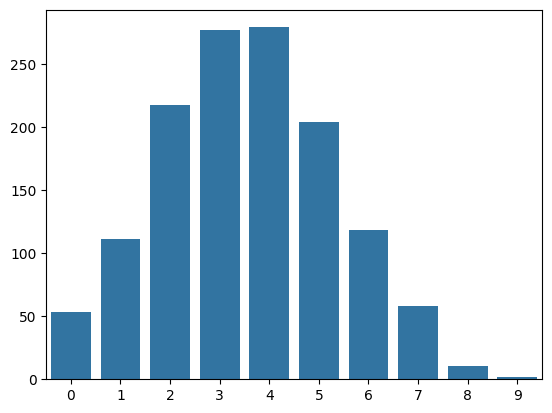

In [16]:
import seaborn as sns

from data import generate_submission

X_submissions = remove_boring_columns(transform_all_house(combined_transformed_test))
X_submissions_scaled = random_forest_preprocessor2.transform(X_submissions)
X_submissions_scaled = selector2.transform(X_submissions_scaled)
X_submissions_scaled = np.column_stack([X_submissions_scaled, X_test_means])

knn_test_means2 = (
    (transformer2.kneighbors_graph(X_submissions_scaled) @ y.T)
    / random_forest_k_neighbors
).reshape(-1, 1)
np.nan_to_num(knn_test_means2, nan=np.nanmean(knn_train_means2), copy=False)

X_submissions_scaled = np.column_stack([X_submissions_scaled, knn_test_means2])
final_y_pred = final_model2.predict_proba(X_submissions_scaled)

generate_submission(final_y_pred, "random-forest")
sns.barplot(final_y_pred.sum(axis=0))